In [1]:
import sys  
sys.path.insert(0, '../script/')

In [108]:
import os
import pandas as pd
import numpy as np

from data import TimeSeriesData, timedata

from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import random
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [99]:
data_dir = '/home/amansinha/Downloads/data/time-series/Le CAC et ses 7 majors 2021-Aman/'

df = pd.read_csv(data_dir + 'AIR.FR-d-20200701.csv', sep=' ', names=['name', 'date', 'time', 'val', 'extra'])

df.drop('extra', axis=1, inplace=True)

df['datetime'] = df[['date', 'time']].agg(' '.join, axis=1)
df['datetime'] = df['datetime'].astype('datetime64[ns]')

df.drop(['date', 'time'], axis=1, inplace=True)
df

,name,val,datetime
0,AIR.FR-d,63.60,2020-01-07 09:00:00
1,AIR.FR-d,63.62,2020-01-07 09:00:15
2,AIR.FR-d,63.67,2020-01-07 09:00:30
3,AIR.FR-d,63.66,2020-01-07 09:00:45
4,AIR.FR-d,63.57,2020-01-07 09:01:00
...,...,...,...
248997,AIR.FR-d,62.70,2020-10-30 17:29:00
248998,AIR.FR-d,62.70,2020-10-30 17:29:15
248999,AIR.FR-d,62.66,2020-10-30 17:29:30
249000,AIR.FR-d,62.64,2020-10-30 17:29:45


In [100]:
ts = TimeSeriesData(df, name='BNP', h=7, k=4)
ts.prepare_data()
datadf = ts.df
datadf.head()

Size of Dataset: 62243


,feat0,feat1,feat2,feat3,feat4,feat5,feat6,Y0
0,63.60,63.57,63.67,63.70,63.73,63.62,63.55,63.30
1,63.57,63.67,63.70,63.73,63.62,63.55,63.30,63.05
2,63.67,63.70,63.73,63.62,63.55,63.30,63.05,63.14
3,63.70,63.73,63.62,63.55,63.30,63.05,63.14,63.02
4,63.73,63.62,63.55,63.30,63.05,63.14,63.02,63.34


In [102]:
import pandas as pd
from sklearn import preprocessing

x = datadf.values #returns a numpy array
scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x.reshape(-1,1))
df = pd.DataFrame(x_scaled.reshape(-1,8))
df.head()

# to inverse transform
#x_scaled_inv = scaler.inverse_transform(df.iloc[:,-1:].values)
#df_inv = pd.DataFrame(x_scaled_inv)
#df_inv.head()

,0,1,2,3,4,5,6,7
0,0.314427,0.312775,0.318282,0.319934,0.321586,0.315529,0.311674,0.297907
1,0.312775,0.318282,0.319934,0.321586,0.315529,0.311674,0.297907,0.284141
2,0.318282,0.319934,0.321586,0.315529,0.311674,0.297907,0.284141,0.289097
3,0.319934,0.321586,0.315529,0.311674,0.297907,0.284141,0.289097,0.282489
4,0.321586,0.315529,0.311674,0.297907,0.284141,0.289097,0.282489,0.300110


In [82]:
n_samples = 62000
datadf = df
traindf, testdf = train_test_split(datadf[:12000], test_size=0.15, random_state=42, shuffle=False)

traindataloader= DataLoader(timedata(traindf, 7), 32, shuffle=True, drop_last=True)
testdataloader= DataLoader(timedata(testdf, 7), 32, shuffle=False, drop_last=True)

In [9]:
import time
import torch
import random
from torch import nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [15]:


class LSTMNet(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, output_dim=1, n_layers=1):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.device = torch.device('cpu')
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        self.hidden = (torch.zeros(1,1,self.hidden_dim),
                            torch.zeros(1,1,self.hidden_dim))
        
    def forward(self, x):
        out, self.hidden = self.lstm(x.view(1, len(x), -1), self.hidden)
        out = self.fc(self.relu(out))
        return out
    
    #def init_hidden(self, batch_size):
     #   weight = next(self.parameters()).data
      #  hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
       #           weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
        #return hidden




In [106]:
def train(trainloader ,params, inpdim,num=None):
    
    input_dim = inpdim
    device = torch.device('cpu')
    #print(f"working with {inpdim} features")#nextitem(iter(trainloader))[0].shape[2]
    output_dim = 1
    n_layers = 2
    batch_size= 32
    
    model = LSTMNet(input_dim, hidden_dim=params['hidden_dim'],
                   output_dim=output_dim)#, bidir=False)
    model.to(device)
    
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'])
    
    if num:
        writer = SummaryWriter(f'runs/gru_experiment_{num}')
        
        
    model.train()
    
    epoch_times  = []
    
    p =0
    
    for epoch in range(params['epochs']):
        
        start = time.time()
        avg_loss = 0
        counter = 0
        
        for x, label in trainloader:
            
            counter +=1
            p +=1
            
            optimizer.zero_grad()
            model.hidden = (torch.zeros(1,1,params['hidden_dim']),
                            torch.zeros(1,1,params['hidden_dim']))
            
            out = model(x.to(device).float())
            
            #print(out.shape, label.shape)
            out = torch.squeeze(out, dim=0)
            loss = criterion(out, label.to(device).float())
            #print(out[:5],'\n', label[:5], '\n')
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            
            if counter % 200 == 0:
                print(f"Epoch : {epoch}, Step: {counter}/{len(trainloader)} ==> Avg Loss for epoch: {avg_loss/counter}")
                if num: writer.add_scalar('training_loss', avg_loss/counter, p)
        
        current_time = time.time()
        #print(f"Total time elapsed: {current_time-start} seconds")
        epoch_times.append(current_time- start)
    
    #print(f"Total Training Time: {sum(epoch_times)} seconds")
    return model



def evaluate(model, testdataloader, params):
    
    device = torch.device('cpu')
    
    model.eval()
    outputs = []
    targets = []
    
    start = time.time()
    with torch.no_grad():
        for x,y in testdataloader:

            model.hidden = (torch.zeros(1,1,params['hidden_dim']),
                                torch.zeros(1,1,params['hidden_dim']))
            out = model(x.to(device))
            out = torch.squeeze(out, dim=0)
            outputs.extend(out.cpu().detach().numpy().squeeze())
            targets.extend(y.numpy())
        
    return np.asarray(outputs)

In [83]:
params = {'lr': 0.001,
         'hidden_dim':256,
         'epochs': 70,
         }

In [84]:
model = train(traindataloader, params, 7)

Epoch : 0, Step: 200/318 ==> Avg Loss for epoch: 0.008715889793747919
Epoch : 1, Step: 200/318 ==> Avg Loss for epoch: 8.776262096034771e-05
Epoch : 2, Step: 200/318 ==> Avg Loss for epoch: 7.186183822341263e-05
Epoch : 3, Step: 200/318 ==> Avg Loss for epoch: 6.270993309499317e-05
Epoch : 4, Step: 200/318 ==> Avg Loss for epoch: 5.615303260583459e-05
Epoch : 5, Step: 200/318 ==> Avg Loss for epoch: 5.344857388990931e-05
Epoch : 6, Step: 200/318 ==> Avg Loss for epoch: 5.374189242047578e-05
Epoch : 7, Step: 200/318 ==> Avg Loss for epoch: 5.1037498017194594e-05
Epoch : 8, Step: 200/318 ==> Avg Loss for epoch: 5.2303086717984116e-05
Epoch : 9, Step: 200/318 ==> Avg Loss for epoch: 5.1156192062080666e-05
Epoch : 10, Step: 200/318 ==> Avg Loss for epoch: 4.14706306582957e-05
Epoch : 11, Step: 200/318 ==> Avg Loss for epoch: 5.2937406376258875e-05
Epoch : 12, Step: 200/318 ==> Avg Loss for epoch: 4.5626495525539214e-05
Epoch : 13, Step: 200/318 ==> Avg Loss for epoch: 3.96454998963236e-05


In [109]:
outputs = evaluate(model, testdataloader, params)

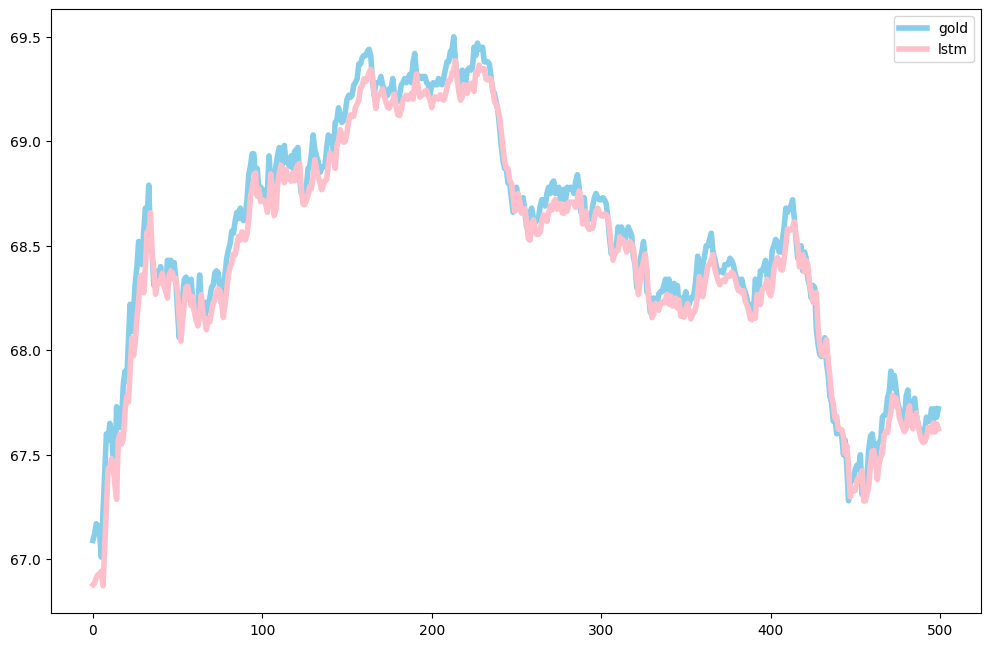

<Figure size 1000x1000 with 0 Axes>

In [110]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100    
    
# Data
#df=pd.DataFrame({'x_values': range(1,11), 'y1_values': np.random.randn(10), 'y2_values': np.random.randn(10)+range(1,11), 'y3_values': np.random.randn(10)+range(11,21) })
truth =  scaler.inverse_transform(testdf.iloc[:,-1:].values)
pred =  scaler.inverse_transform(outputs.reshape(-1, 1))   
    
# multiple line plots
plt.plot(list(range(len(outputs)))[:500], truth[:500], marker=' ', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4, label='gold')
plt.plot( list(range(len(outputs)))[:500], pred[:500], marker=' ', markerfacecolor='blue', markersize=12, color='pink', linewidth=4, label='lstm')
#plt.plot( list(range(len(outputs))), outputs_gru, marker=' ', markerfacecolor='blue', markersize=12, color='green', linewidth=4, label='gru')

#plt.plot( 'x_values', 'y2_values', data=df, marker='', color='olive', linewidth=2)
#plt.plot( 'x_values', 'y3_values', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
# show legend
plt.legend()

def s(value): a = value; return (a,a) 

plt.figure(figsize=(s(10)))
# show graph
plt.show()